# XGBoost KOI Feature Training
Using sklearn package to train a XGBoost model for koi features

## Import Packages

In [1]:
import numpy as np
import csv
import pandas as pd
import glob
import os
import re
import math
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

### Import Packages about XGBoost

In [2]:
from sklearn.utils import shuffle
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, KFold, GridSearchCV

## Mount Google Cloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Specify the folder path inside your Google Drive

In [4]:
import os
folder_path = '/content/drive/My Drive/koi_features_csv'

### List and Process Files

In [5]:
# List all CSV files in the folder
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"Found {len(all_files)} CSV files.")

# Combine all CSV files into a single DataFrame
combined_df = pd.DataFrame()

for file in all_files:
    file_path = os.path.join(folder_path, file)
    print(f"Processing file: {file}")
    # Use the first column as the index
    df = pd.read_csv(file_path, index_col=0)
    combined_df = pd.concat([combined_df, df])

# Sort the combined DataFrame by index
combined_df = combined_df.sort_index()

Found 1 CSV files.
Processing file: koi_features_correct.csv


In [6]:
# Display the sorted DataFrame
combined_df

,light_curve__variance_larger_than_standard_deviation,light_curve__has_duplicate_max,light_curve__has_duplicate_min,light_curve__has_duplicate,light_curve__sum_values,light_curve__abs_energy,light_curve__mean_abs_change,light_curve__mean_change,light_curve__mean_second_derivative_central,light_curve__median,...,light_curve__fourier_entropy__bins_10,light_curve__fourier_entropy__bins_100,light_curve__permutation_entropy__dimension_3__tau_1,light_curve__permutation_entropy__dimension_4__tau_1,light_curve__permutation_entropy__dimension_5__tau_1,light_curve__permutation_entropy__dimension_6__tau_1,light_curve__permutation_entropy__dimension_7__tau_1,light_curve__query_similarity_count__query_None__threshold_0.0,light_curve__mean_n_absolute_max__number_of_maxima_7,label
K00001.01,0.0,0.0,0.0,0.0,-14.515241,0.162918,0.001681,1.099754e-10,7.182222e-09,-0.000024,...,0.335886,1.316350,1.748952,3.037498,4.429284,5.862808,7.100560,NaN,0.014371,1
K00002.01,0.0,0.0,0.0,0.0,-26.920699,0.159873,0.000439,-1.627660e-10,-1.518303e-09,-0.000023,...,0.307703,0.933678,1.731508,2.996228,4.415931,5.924201,7.389087,NaN,0.006885,1
K00003.01,0.0,0.0,0.0,0.0,-3.564002,0.013091,0.000452,9.466150e-08,5.234058e-08,-0.000041,...,0.294982,1.092041,1.718824,2.945590,4.277767,5.594682,6.665248,NaN,0.004642,1
K00004.01,0.0,0.0,0.0,0.0,-1.423667,0.002174,0.000193,-2.433665e-08,-1.537045e-08,-0.000083,...,0.542768,1.528460,1.726372,2.981621,4.388778,5.851644,7.132916,NaN,0.002089,1
K00005.01,0.0,0.0,0.0,0.0,-0.753888,0.000629,0.000108,-3.316851e-08,1.844653e-08,-0.000008,...,1.189758,2.624202,1.784199,3.154884,4.726861,6.428579,8.059684,NaN,0.001099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K01426.03,0.0,0.0,0.0,0.0,-0.211190,0.000857,0.000293,-1.190000e-07,2.030000e-08,-0.000021,...,1.109130,2.392529,1.790647,3.173246,4.761921,6.422724,7.549194,NaN,0.004480,1
K01427.01,0.0,0.0,0.0,0.0,-0.759302,0.004511,0.000690,-4.590000e-08,1.340000e-08,-0.000084,...,1.449702,3.415588,1.791207,3.175518,4.777585,6.538010,8.233138,NaN,0.003047,1
K01427.02,0.0,0.0,0.0,0.0,-0.170746,0.004152,0.000684,-4.590000e-08,1.340000e-08,-0.000034,...,1.571996,3.572263,1.791411,3.176432,4.780017,6.542422,8.242972,NaN,0.003113,0
K01428.01,0.0,0.0,0.0,0.0,-1.782915,0.002321,0.000320,-2.800000e-10,-6.660000e-09,-0.000071,...,0.539976,2.068889,1.789109,3.164662,4.754468,6.505948,8.301465,NaN,0.001543,1


In [7]:
# Check for duplicate indices in combined_df
duplicate_indices_combined = combined_df.index[combined_df.index.duplicated(keep=False)]

if not duplicate_indices_combined.empty:
    print("Duplicate indices found in combined_df:")
    print(duplicate_indices_combined)
else:
    print("No duplicate indices found in combined_df.")

No duplicate indices found in combined_df.


In [8]:
# Load the second CSV file with the first column as the index
comparison_file_path = '/content/drive/My Drive/q1_q17_dr25_koi.csv'
comparison_df = pd.read_csv(comparison_file_path, index_col=1)
comparison_df = comparison_df.iloc[:1886]

# Find the missing indices
missing_indices = comparison_df.index.difference(combined_df.index)

# Display the missing indices
if missing_indices.empty:
    print("No missing indices found.")
else:
  print("Missing indices:")
  print(missing_indices)

Missing indices:
Index(['K00787.01', 'K00787.02', 'K00787.03', 'K00930.01', 'K00961.01',
       'K00961.02', 'K00961.03', 'K00966.01', 'K01000.01', 'K01013.01',
       'K01021.01', 'K01037.01', 'K01045.01', 'K01047.01', 'K01060.04',
       'K01064.01', 'K01087.01', 'K01093.01', 'K01107.01', 'K01122.01'],
      dtype='object')


In [9]:
comparison_df

,kepid,kepler_name,koi_disposition,koi_pdisposition
kepoi_name,,,,
K00001.01,11446443,Kepler-1 b,CONFIRMED,CANDIDATE
K00002.01,10666592,Kepler-2 b,CONFIRMED,CANDIDATE
K00003.01,10748390,Kepler-3 b,CONFIRMED,CANDIDATE
K00004.01,3861595,Kepler-1658 b,CONFIRMED,CANDIDATE
K00005.01,8554498,NaN,CANDIDATE,CANDIDATE
...,...,...,...,...
K01426.03,11122894,Kepler-297 d,CONFIRMED,CANDIDATE
K01427.01,11129738,Kepler-844 b,CONFIRMED,CANDIDATE
K01427.02,11129738,NaN,CANDIDATE,CANDIDATE


## Data Preprocess
### Drop Columns that is useless and with NaN values

In [10]:
# Identify columns with all the same values or entirely NaN
same_value_columns = []
same_value_data = {}  # Dictionary to store the value each same column holds
nan_columns = []

# Check for columns with a single unique value
for col in combined_df.columns:
    if combined_df[col].nunique(dropna=True) == 1:  # Only one unique value (ignoring NaNs)
        # Store the unique value for columns with the same value
        unique_value = combined_df[col].dropna().iloc[0]  # Get the non-NaN value
        same_value_columns.append(col)
        same_value_data[col] = unique_value

# Check for columns with all NaN values
nan_columns = combined_df.columns[combined_df.isna().all()].tolist()

# Print out the results
print("Columns with the same value:")
for col in same_value_columns:
    print(f"{col}: {same_value_data[col]}")

print("\nColumns with all NaN values:")
print(nan_columns)

# Combine columns to drop
columns_to_drop = list(set(same_value_columns + nan_columns))

# Remove duplicates in case of overlap
columns_to_drop = list(set(columns_to_drop))

# List the columns to drop
print("Columns to drop:", columns_to_drop)

Columns with the same value:
light_curve__variance_larger_than_standard_deviation: 0.0
light_curve__has_duplicate_max: 0.0
light_curve__has_duplicate_min: 0.0
light_curve__has_duplicate: 0.0
light_curve__percentage_of_reoccurring_values_to_all_values: 0.0
light_curve__percentage_of_reoccurring_datapoints_to_all_datapoints: 0.0
light_curve__sum_of_reoccurring_values: 0.0
light_curve__sum_of_reoccurring_data_points: 0.0
light_curve__ratio_value_number_to_time_series_length: 1.0
light_curve__symmetry_looking__r_0.0: 0.0
light_curve__symmetry_looking__r_0.2: 1.0
light_curve__symmetry_looking__r_0.25: 1.0
light_curve__symmetry_looking__r_0.30000000000000004: 1.0
light_curve__symmetry_looking__r_0.35000000000000003: 1.0
light_curve__symmetry_looking__r_0.4: 1.0
light_curve__symmetry_looking__r_0.45: 1.0
light_curve__symmetry_looking__r_0.5: 1.0
light_curve__symmetry_looking__r_0.55: 1.0
light_curve__symmetry_looking__r_0.6000000000000001: 1.0
light_curve__symmetry_looking__r_0.65: 1.0
light_

### Drop the identified columns

In [11]:
koi_features = combined_df.drop(columns=columns_to_drop)

In [12]:
koi_features

,light_curve__sum_values,light_curve__abs_energy,light_curve__mean_abs_change,light_curve__mean_change,light_curve__mean_second_derivative_central,light_curve__median,light_curve__mean,light_curve__length,light_curve__standard_deviation,light_curve__variation_coefficient,...,light_curve__fourier_entropy__bins_5,light_curve__fourier_entropy__bins_10,light_curve__fourier_entropy__bins_100,light_curve__permutation_entropy__dimension_3__tau_1,light_curve__permutation_entropy__dimension_4__tau_1,light_curve__permutation_entropy__dimension_5__tau_1,light_curve__permutation_entropy__dimension_6__tau_1,light_curve__permutation_entropy__dimension_7__tau_1,light_curve__mean_n_absolute_max__number_of_maxima_7,label
K00001.01,-14.515241,0.162918,0.001681,1.099754e-10,7.182222e-09,-0.000024,-0.001982,7323.0,0.004280,-2.159289,...,0.262742,0.335886,1.316350,1.748952,3.037498,4.429284,5.862808,7.100560,0.014371,1
K00002.01,-26.920699,0.159873,0.000439,-1.627660e-10,-1.518303e-09,-0.000023,-0.001288,20905.0,0.002447,-1.900421,...,0.247940,0.307703,0.933678,1.731508,2.996228,4.415931,5.924201,7.389087,0.006885,1
K00003.01,-3.564002,0.013091,0.000452,9.466150e-08,5.234058e-08,-0.000041,-0.000801,4449.0,0.001517,-1.893456,...,0.204871,0.294982,1.092041,1.718824,2.945590,4.277767,5.594682,6.665248,0.004642,1
K00004.01,-1.423667,0.002174,0.000193,-2.433665e-08,-1.537045e-08,-0.000083,-0.000212,6706.0,0.000528,-2.488455,...,0.288307,0.542768,1.528460,1.726372,2.981621,4.388778,5.851644,7.132916,0.002089,1
K00005.01,-0.753888,0.000629,0.000108,-3.316851e-08,1.844653e-08,-0.000008,-0.000067,11238.0,0.000227,-3.381366,...,0.637486,1.189758,2.624202,1.784199,3.154884,4.726861,6.428579,8.059684,0.001099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K01426.03,-0.211190,0.000857,0.000293,-1.190000e-07,2.030000e-08,-0.000021,-0.000077,2731.0,0.000555,-7.173374,...,0.801632,1.109130,2.392529,1.790647,3.173246,4.761921,6.422724,7.549194,0.004480,1
K01427.01,-0.759302,0.004511,0.000690,-4.590000e-08,1.340000e-08,-0.000084,-0.000074,10195.0,0.000661,-8.875576,...,0.828806,1.449702,3.415588,1.791207,3.175518,4.777585,6.538010,8.233138,0.003047,1
K01427.02,-0.170746,0.004152,0.000684,-4.590000e-08,1.340000e-08,-0.000034,-0.000017,10195.0,0.000638,-38.092941,...,0.968468,1.571996,3.572263,1.791411,3.176432,4.780017,6.542422,8.242972,0.003113,0
K01428.01,-1.782915,0.002321,0.000320,-2.800000e-10,-6.660000e-09,-0.000071,-0.000086,20781.0,0.000323,-3.764553,...,0.235155,0.539976,2.068889,1.789109,3.164662,4.754468,6.505948,8.301465,0.001543,1


### Check for rows that contains 'inf' value

In [13]:
inf_columns = koi_features.columns[(koi_features == float('inf')).any() | (koi_features == float('-inf')).any()]

# Loop through each column with inf values and display the indices
for col in inf_columns:
    # Get the indices of rows where the column has inf values
    inf_indices = koi_features[koi_features[col].isin([float('inf'), float('-inf')])].index
    print(f"Indices with inf values in column '{col}':")
    print(inf_indices)

In [14]:
# Drop rows where any column has inf values
koi_features = koi_features[~koi_features.isin([float('inf'), float('-inf')]).any(axis=1)]
print("Shape of the cleaned data:", koi_features.shape)

Shape of the cleaned data: (1866, 739)


### Check for rows that contains 'nan' value

In [15]:
# Find rows and columns with NaN values
nan_rows_cols = koi_features[koi_features.isna().any(axis=1)]

if not nan_rows_cols.empty:
    print("Rows and columns with NaN values:")
    for index, row in nan_rows_cols.iterrows():
        nan_cols = row.index[row.isna()]
        print(f"Row index: {index}, Columns with NaN: {list(nan_cols)}")
else:
    print("No NaN values found in the DataFrame.")

Rows and columns with NaN values:
Row index: K00041.01, Columns with NaN: ['light_curve__autocorrelation__lag_0', 'light_curve__autocorrelation__lag_1', 'light_curve__autocorrelation__lag_2', 'light_curve__autocorrelation__lag_3', 'light_curve__autocorrelation__lag_4', 'light_curve__autocorrelation__lag_5', 'light_curve__autocorrelation__lag_6', 'light_curve__autocorrelation__lag_7', 'light_curve__autocorrelation__lag_8', 'light_curve__autocorrelation__lag_9']
Row index: K00041.02, Columns with NaN: ['light_curve__autocorrelation__lag_0', 'light_curve__autocorrelation__lag_1', 'light_curve__autocorrelation__lag_2', 'light_curve__autocorrelation__lag_3', 'light_curve__autocorrelation__lag_4', 'light_curve__autocorrelation__lag_5', 'light_curve__autocorrelation__lag_6', 'light_curve__autocorrelation__lag_7', 'light_curve__autocorrelation__lag_8', 'light_curve__autocorrelation__lag_9']
Row index: K00041.03, Columns with NaN: ['light_curve__autocorrelation__lag_0', 'light_curve__autocorrel

In [16]:
# Fill all the nan value with 0
koi_features = koi_features.fillna(0)

In [17]:
# Find rows and columns with NaN values
nan_rows_cols = koi_features[koi_features.isna().any(axis=1)]

if not nan_rows_cols.empty:
    print("Rows and columns with NaN values:")
    for index, row in nan_rows_cols.iterrows():
        nan_cols = row.index[row.isna()]
        print(f"Row index: {index}, Columns with NaN: {list(nan_cols)}")
else:
    print("No NaN values found in the DataFrame.")

No NaN values found in the DataFrame.


### Code to Extract label Column and Separate It from koi_features

In [18]:
# Extract the 'label' column as the target for training
koi_labels = koi_features.pop('label')

In [19]:
koi_labels

,label
K00001.01,1
K00002.01,1
K00003.01,1
K00004.01,1
K00005.01,0
...,...
K01426.03,1
K01427.01,1
K01427.02,0
K01428.01,1


In [20]:
# Show the distribution of Label
koi_labels.value_counts()

,count
label,
1,1216
0,650


In [21]:
koi_features

,light_curve__sum_values,light_curve__abs_energy,light_curve__mean_abs_change,light_curve__mean_change,light_curve__mean_second_derivative_central,light_curve__median,light_curve__mean,light_curve__length,light_curve__standard_deviation,light_curve__variation_coefficient,...,light_curve__fourier_entropy__bins_3,light_curve__fourier_entropy__bins_5,light_curve__fourier_entropy__bins_10,light_curve__fourier_entropy__bins_100,light_curve__permutation_entropy__dimension_3__tau_1,light_curve__permutation_entropy__dimension_4__tau_1,light_curve__permutation_entropy__dimension_5__tau_1,light_curve__permutation_entropy__dimension_6__tau_1,light_curve__permutation_entropy__dimension_7__tau_1,light_curve__mean_n_absolute_max__number_of_maxima_7
K00001.01,-14.515241,0.162918,0.001681,1.099754e-10,7.182222e-09,-0.000024,-0.001982,7323.0,0.004280,-2.159289,...,0.155665,0.262742,0.335886,1.316350,1.748952,3.037498,4.429284,5.862808,7.100560,0.014371
K00002.01,-26.920699,0.159873,0.000439,-1.627660e-10,-1.518303e-09,-0.000023,-0.001288,20905.0,0.002447,-1.900421,...,0.110453,0.247940,0.307703,0.933678,1.731508,2.996228,4.415931,5.924201,7.389087,0.006885
K00003.01,-3.564002,0.013091,0.000452,9.466150e-08,5.234058e-08,-0.000041,-0.000801,4449.0,0.001517,-1.893456,...,0.110453,0.204871,0.294982,1.092041,1.718824,2.945590,4.277767,5.594682,6.665248,0.004642
K00004.01,-1.423667,0.002174,0.000193,-2.433665e-08,-1.537045e-08,-0.000083,-0.000212,6706.0,0.000528,-2.488455,...,0.190068,0.288307,0.542768,1.528460,1.726372,2.981621,4.388778,5.851644,7.132916,0.002089
K00005.01,-0.753888,0.000629,0.000108,-3.316851e-08,1.844653e-08,-0.000008,-0.000067,11238.0,0.000227,-3.381366,...,0.361788,0.637486,1.189758,2.624202,1.784199,3.154884,4.726861,6.428579,8.059684,0.001099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K01426.03,-0.211190,0.000857,0.000293,-1.190000e-07,2.030000e-08,-0.000021,-0.000077,2731.0,0.000555,-7.173374,...,0.547887,0.801632,1.109130,2.392529,1.790647,3.173246,4.761921,6.422724,7.549194,0.004480
K01427.01,-0.759302,0.004511,0.000690,-4.590000e-08,1.340000e-08,-0.000084,-0.000074,10195.0,0.000661,-8.875576,...,0.804632,0.828806,1.449702,3.415588,1.791207,3.175518,4.777585,6.538010,8.233138,0.003047
K01427.02,-0.170746,0.004152,0.000684,-4.590000e-08,1.340000e-08,-0.000034,-0.000017,10195.0,0.000638,-38.092941,...,0.451173,0.968468,1.571996,3.572263,1.791411,3.176432,4.780017,6.542422,8.242972,0.003113
K01428.01,-1.782915,0.002321,0.000320,-2.800000e-10,-6.660000e-09,-0.000071,-0.000086,20781.0,0.000323,-3.764553,...,0.155665,0.235155,0.539976,2.068889,1.789109,3.164662,4.754468,6.505948,8.301465,0.001543


## Model Training


### Train with 1-1600 Dataset, Test with the 1601-2000

In [22]:
train_features = koi_features.loc[:'K01126.01']
train_labels = koi_labels.loc[:'K01126.01']

test_features = koi_features.loc['K01126.02':]
test_labels = koi_labels.loc['K01126.02':]

In [23]:
test_features

,light_curve__sum_values,light_curve__abs_energy,light_curve__mean_abs_change,light_curve__mean_change,light_curve__mean_second_derivative_central,light_curve__median,light_curve__mean,light_curve__length,light_curve__standard_deviation,light_curve__variation_coefficient,...,light_curve__fourier_entropy__bins_3,light_curve__fourier_entropy__bins_5,light_curve__fourier_entropy__bins_10,light_curve__fourier_entropy__bins_100,light_curve__permutation_entropy__dimension_3__tau_1,light_curve__permutation_entropy__dimension_4__tau_1,light_curve__permutation_entropy__dimension_5__tau_1,light_curve__permutation_entropy__dimension_6__tau_1,light_curve__permutation_entropy__dimension_7__tau_1,light_curve__mean_n_absolute_max__number_of_maxima_7
K01126.02,-0.092885,0.002374,0.000502,-3.420000e-08,1.240000e-08,-0.000009,-0.000010,9461.0,0.000501,-51.017753,...,0.190068,0.215617,0.841726,2.435080,1.791641,3.177345,4.781786,6.540501,8.217088,0.002395
K01127.01,-0.748593,0.006578,0.000632,1.290000e-08,-5.350000e-08,-0.000058,-0.000044,17220.0,0.000617,-14.182610,...,0.531730,1.028215,1.391669,3.110345,1.791693,3.177256,4.783148,6.557539,8.367366,0.003196
K01127.02,-0.187043,0.006203,0.000631,1.290000e-08,-5.350000e-08,-0.000036,-0.000011,17220.0,0.000600,-55.246922,...,0.526058,0.579791,1.108839,3.070177,1.791731,3.177640,4.784174,6.558324,8.365783,0.003031
K01127.03,-0.333628,0.006213,0.000631,1.290000e-08,-5.350000e-08,-0.000040,-0.000019,17220.0,0.000600,-30.986370,...,0.526058,0.592989,1.059183,3.054354,1.791661,3.177495,4.783886,6.558519,8.367731,0.003059
K01128.01,-0.780307,0.000550,0.000158,-2.020000e-09,1.650000e-09,-0.000031,-0.000035,22090.0,0.000154,-4.354981,...,0.155665,0.262742,0.714508,1.928744,1.790946,3.173299,4.773050,6.538509,8.362912,0.000678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K01426.03,-0.211190,0.000857,0.000293,-1.190000e-07,2.030000e-08,-0.000021,-0.000077,2731.0,0.000555,-7.173374,...,0.547887,0.801632,1.109130,2.392529,1.790647,3.173246,4.761921,6.422724,7.549194,0.004480
K01427.01,-0.759302,0.004511,0.000690,-4.590000e-08,1.340000e-08,-0.000084,-0.000074,10195.0,0.000661,-8.875576,...,0.804632,0.828806,1.449702,3.415588,1.791207,3.175518,4.777585,6.538010,8.233138,0.003047
K01427.02,-0.170746,0.004152,0.000684,-4.590000e-08,1.340000e-08,-0.000034,-0.000017,10195.0,0.000638,-38.092941,...,0.451173,0.968468,1.571996,3.572263,1.791411,3.176432,4.780017,6.542422,8.242972,0.003113
K01428.01,-1.782915,0.002321,0.000320,-2.800000e-10,-6.660000e-09,-0.000071,-0.000086,20781.0,0.000323,-3.764553,...,0.155665,0.235155,0.539976,2.068889,1.789109,3.164662,4.754468,6.505948,8.301465,0.001543


### Initialize the XGBoost model

In [37]:
# Ensure the data is in the correct format
X = train_features  # Features (training data)
y = train_labels   # Labels (target data)

# Compute class weights
scale_pos_weight = sum(y == 0) / len(y)

# Initialize the XGBoost model with custom hyperparameters
model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=250,
    learning_rate=0.05,
    max_depth=5,
    objective='binary:logistic',
    gamma=1,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8
)

In [25]:
scale_pos_weight

0.312625250501002

Accuracy: 0.8022
F1 Score: 0.8084
Precision: 0.7938
Recall: 0.8235


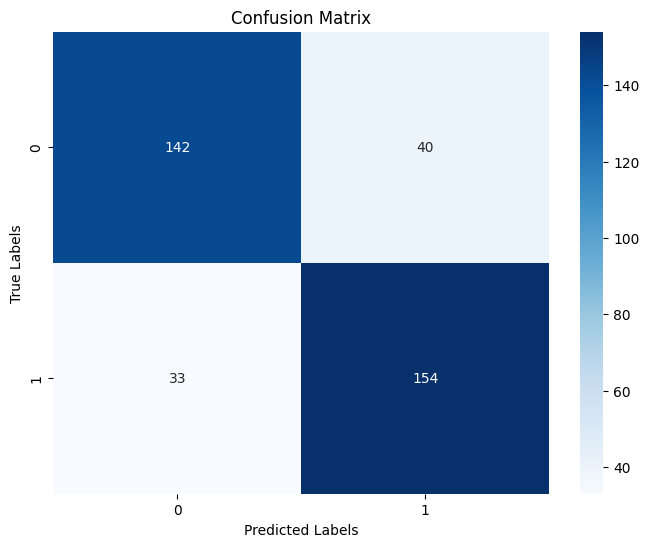

In [38]:
model.fit(train_features, train_labels)

# Predict on test data
predictions = model.predict(test_features)

# Calculate metrics
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### K-Fold Cross-Validation

In [ ]:
# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=25)  # shuffle=True ensures random shuffling

# List to store classification reports for each fold
reports = []

# Initialize lists to store precision, recall, and F1 for each fold
precisions = []
recalls = []
f1_scores = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate classification report for this fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    print(f"Classification Report for fold {len(reports)}:")
    print(classification_report(y_test, y_pred))

    # Extract precision, recall, and F1-score for each class
    precision_class_0 = report['0']['precision']
    recall_class_0 = report['0']['recall']
    f1_class_0 = report['0']['f1-score']

    precision_class_1 = report['1']['precision']
    recall_class_1 = report['1']['recall']
    f1_class_1 = report['1']['f1-score']

    # Append the metrics for each fold
    precisions.append([precision_class_0, precision_class_1])
    recalls.append([recall_class_0, recall_class_1])
    f1_scores.append([f1_class_0, f1_class_1])

# Calculate the average of precision, recall, and F1-score for each class across all folds
average_precision = np.mean(precisions, axis=0)
average_recall = np.mean(recalls, axis=0)
average_f1 = np.mean(f1_scores, axis=0)

# Print the average metrics
print("\nAverage Precision, Recall, and F1-Score across all folds:")
print(f"Class 0 - Precision: {average_precision[0]}, Recall: {average_recall[0]}, F1-Score: {average_f1[0]}")
print(f"Class 1 - Precision: {average_precision[1]}, Recall: {average_recall[1]}, F1-Score: {average_f1[1]}")

Classification Report for fold 1:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       147
           1       0.83      0.93      0.88       246

    accuracy                           0.84       393
   macro avg       0.84      0.81      0.82       393
weighted avg       0.84      0.84      0.83       393

Classification Report for fold 2:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       143
           1       0.88      0.92      0.90       249

    accuracy                           0.87       392
   macro avg       0.86      0.85      0.86       392
weighted avg       0.87      0.87      0.87       392

Classification Report for fold 3:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       148
           1       0.84      0.94      0.89       244

    accuracy                           0.85       392
   macro avg       0.86   

In [ ]:
# Get the feature importance from the trained model
feature_importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance (descending order)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Display the sorted features
print("Sorted Feature Importance:")
for feature, score in sorted_features[0:50]:
    print(f"{feature}: {score}")

Sorted Feature Importance:
light_curve__fft_coefficient__attr_"abs"__coeff_4: 64.0
light_curve__sum_values: 43.0
light_curve__ar_coefficient__coeff_2__k_10: 43.0
light_curve__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC": 40.0
light_curve__ratio_beyond_r_sigma__r_3: 33.0
light_curve__ratio_beyond_r_sigma__r_1.5: 28.0
light_curve__variation_coefficient: 25.0
light_curve__fft_coefficient__attr_"imag"__coeff_60: 24.0
light_curve__fourier_entropy__bins_2: 22.0
light_curve__fft_coefficient__attr_"abs"__coeff_5: 21.0
light_curve__friedrich_coefficients__coeff_0__m_3__r_30: 18.0
light_curve__energy_ratio_by_chunks__num_segments_10__segment_focus_3: 17.0
light_curve__energy_ratio_by_chunks__num_segments_10__segment_focus_7: 17.0
light_curve__autocorrelation__lag_9: 16.0
light_curve__energy_ratio_by_chunks__num_segments_10__segment_focus_1: 16.0
light_curve__permutation_entropy__dimension_7__tau_1: 16.0
light_curve__partial_autocorrelation__lag_2: 15.0
light_curve__fft_coefficient__att